In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [3]:
# size of the test chess board
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

In [23]:
# reading images for cliabration
cal_images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

In [24]:
# resizing images (some of them were not 720 by 1280), collecting corners locations
for cal_img in cal_images:
    img = mpimg.imread(cal_img)
    if img.shape != (720, 1280, 3):
        img = cv2.resize(img, (1280, 720))
        print(cal_img, 'was resized')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

camera_cal/calibration7.jpg was resized
camera_cal/calibration15.jpg was resized


In [25]:
# creating calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

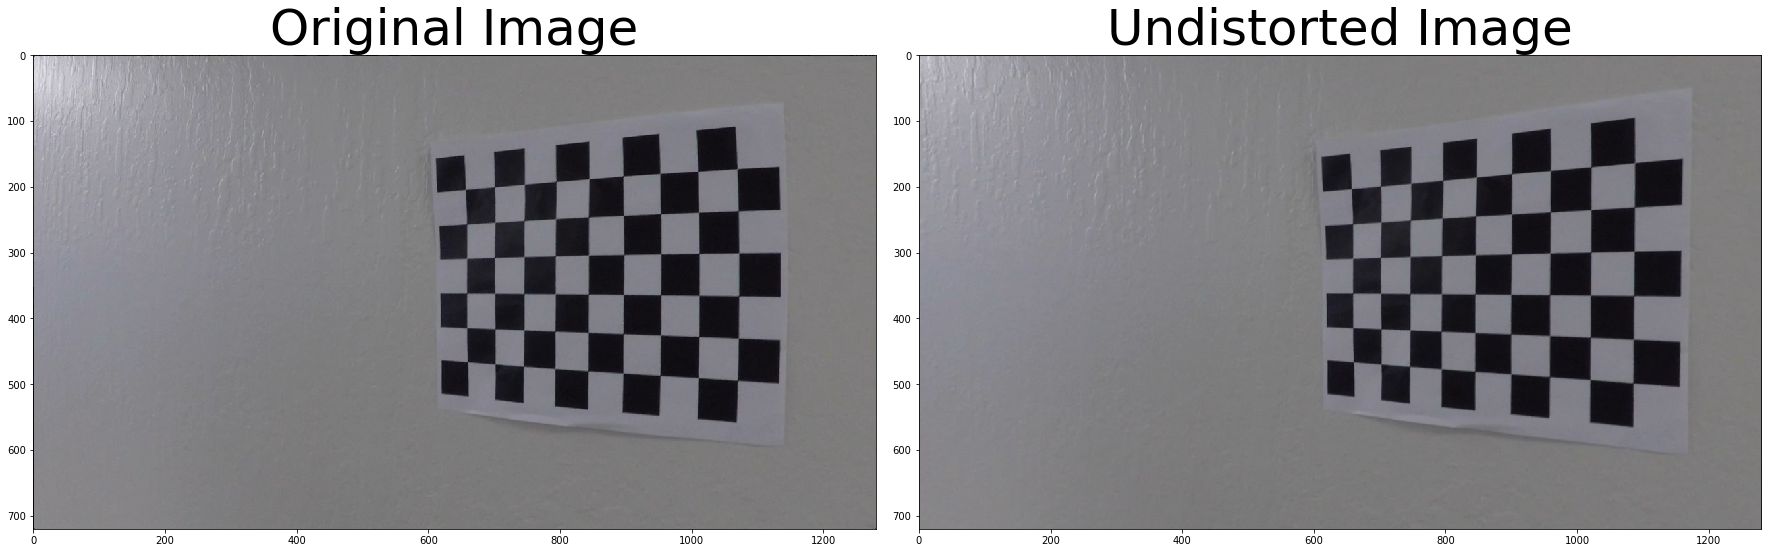

In [27]:
# undistorting with calculated matrix, draw corners
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

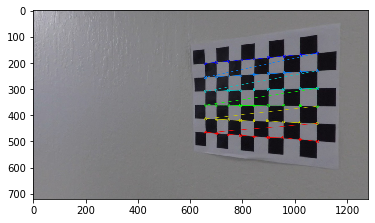

In [28]:
# find chess square corners, draw them
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
plt.imshow(undist)

In [29]:
offset = 100 # offset for dst points
# Grab the image shape
imshape = (gray.shape[1], gray.shape[0])
# get source and destination points
src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
dst = np.float32([[offset, offset],
                  [imshape[0]-offset, offset], 
                  [imshape[0]-offset, imshape[1]-offset], 
                  [offset, imshape[1]-offset]])
# calculate perspective tranform matrix
M = cv2.getPerspectiveTransform(src, dst)

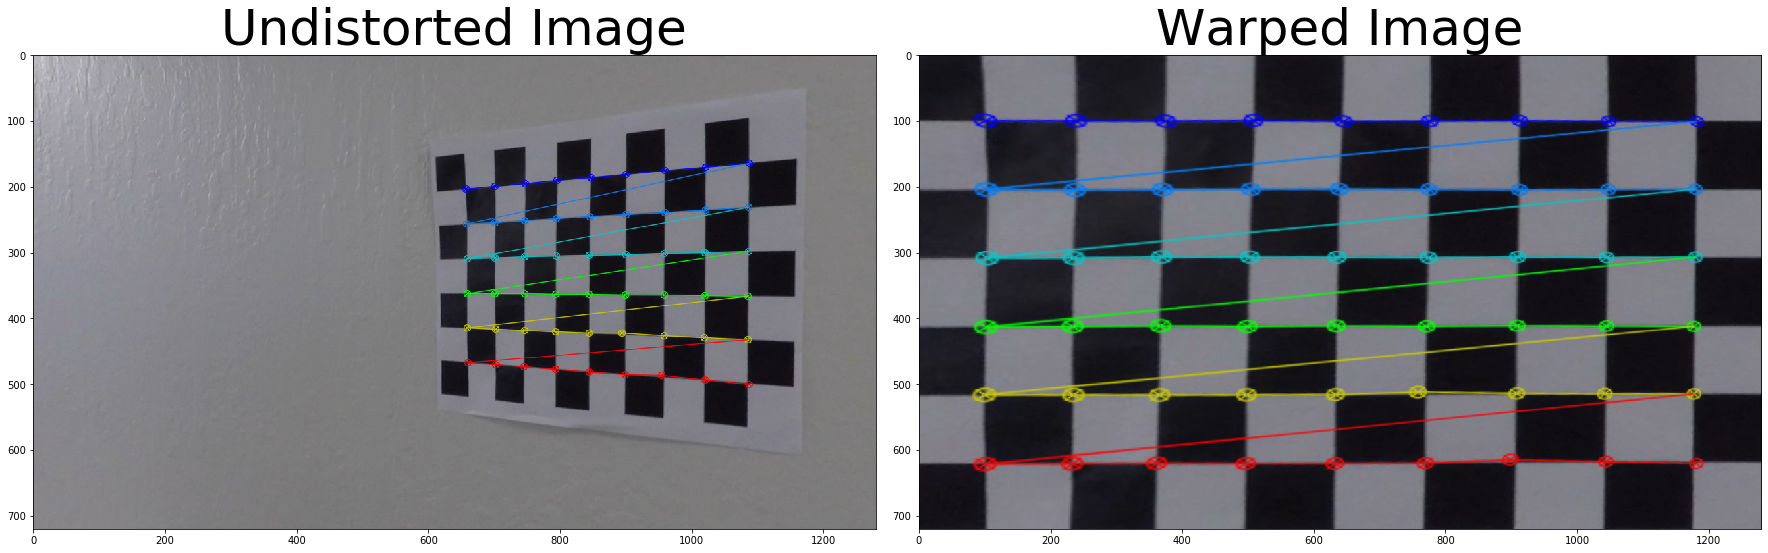

In [30]:
# create warped version of the chessboard image
warped = cv2.warpPerspective(undist, M, (gray.shape[1], gray.shape[0]), flags=cv2.INTER_LINEAR)
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

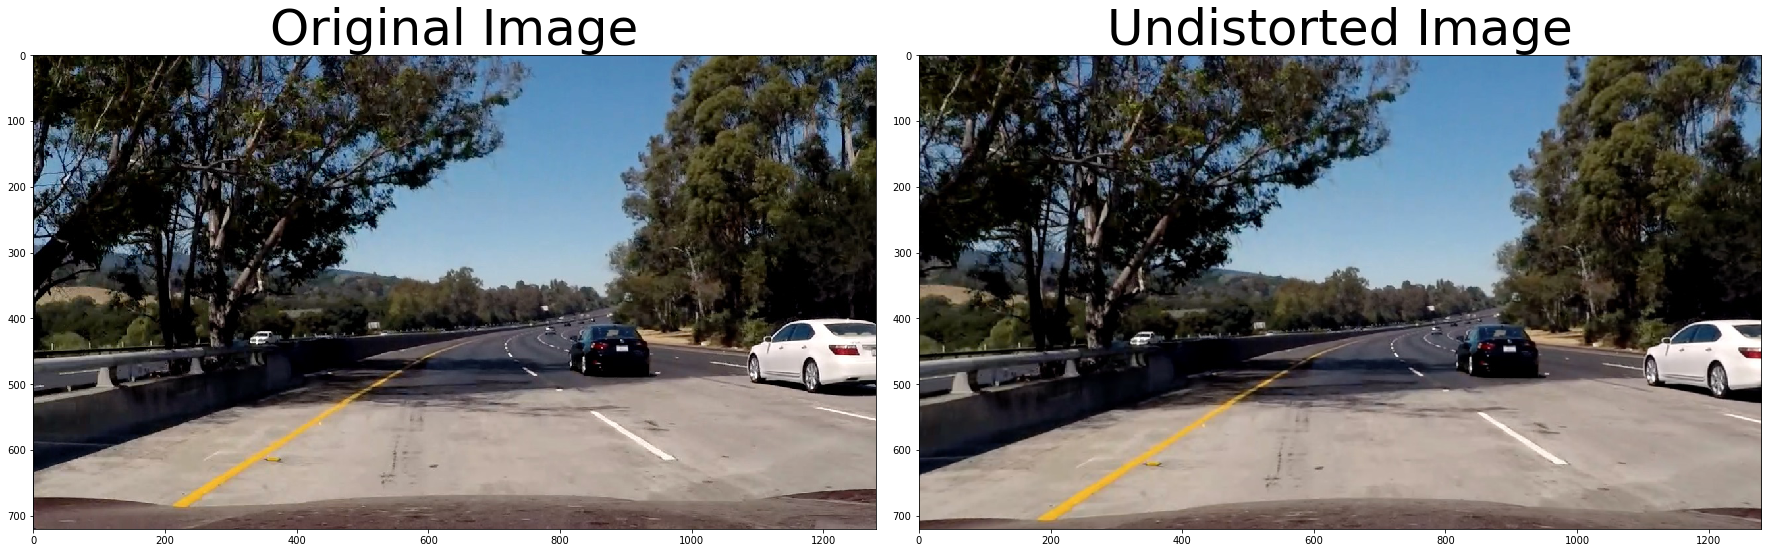

In [50]:
# moving on to road images
rd = mpimg.imread('test_images/test5.jpg')
rd_und = cv2.undistort(rd, mtx, dist, None, mtx)
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rd)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(rd_und)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [33]:
# for warp transform i'm using trapezoidal road lane region
imshape = rd_und.shape
offset = 300 # offset for dst points
src = np.float32([(imshape[1]*0.45, imshape[0]*0.64),
                  (imshape[1]*0.55, imshape[0]*0.64),
                  (imshape[1]*0.85,imshape[0]),
                  (imshape[1]*0.15,imshape[0])])

dst = np.float32([[offset, 0],
                  [imshape[1]-offset, 0], 
                  [imshape[1]-offset, imshape[0]], 
                  [offset, imshape[0]]])

# calculating perspective transform matrix and its reverse for future use
M = cv2.getPerspectiveTransform(src, dst)
M_reverse = cv2.getPerspectiveTransform(dst, src)

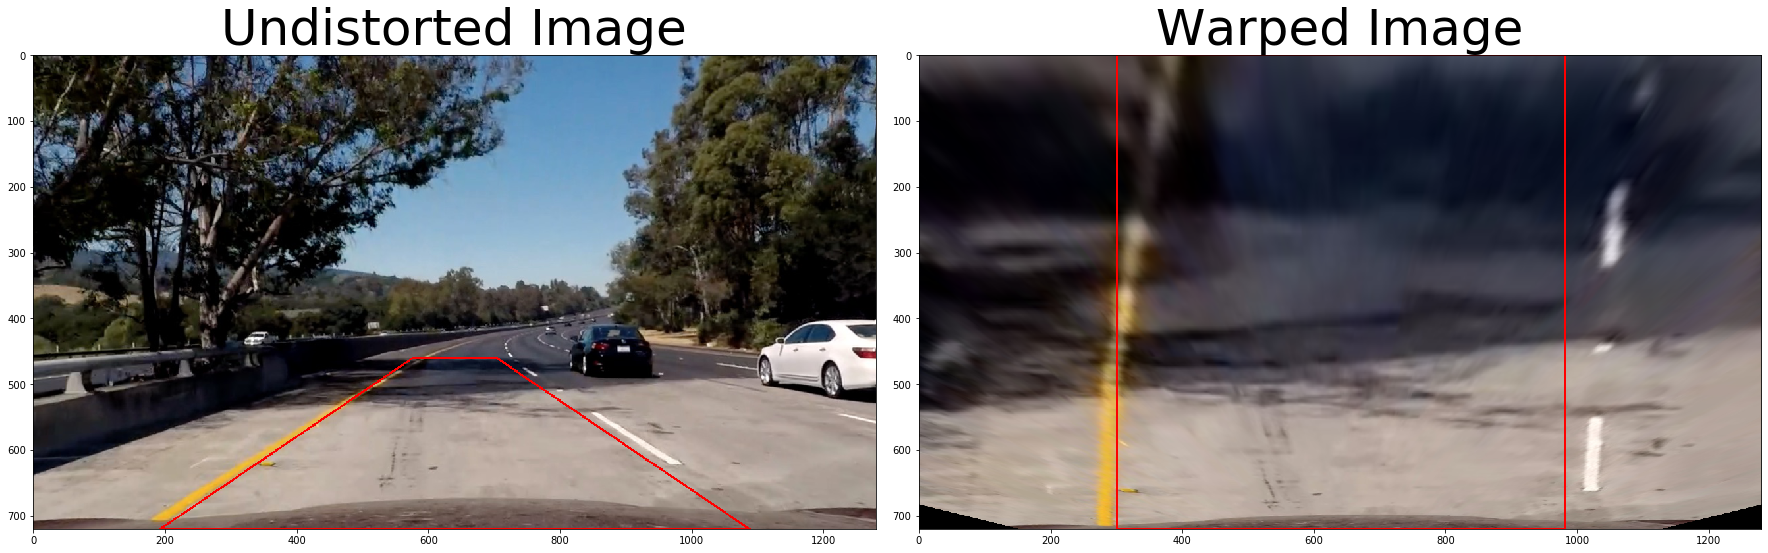

In [51]:
# testing warp
wrd = cv2.warpPerspective(rd_und, M, (rd.shape[1], rd.shape[0]), flags=cv2.INTER_LINEAR)
cv2.polylines(rd_und, np.int32([src]), 1, (255,0,0), thickness=2)
cv2.polylines(wrd, np.int32([dst]), 1, (255,0,0), thickness=2)
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rd_und)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(wrd)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

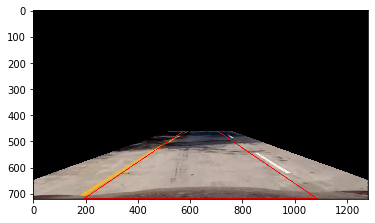

In [49]:
# testin reversibility
wrd_rev = cv2.warpPerspective(wrd, M_reverse, (rd.shape[1], rd.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(wrd_rev)

In [52]:
# creating pipeline for binary image creation
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # bw version
    bw_binary = np.zeros_like(scaled_sobel)
    bw_binary[(sxbinary==1) | (s_binary==1)] = 1
    return bw_binary

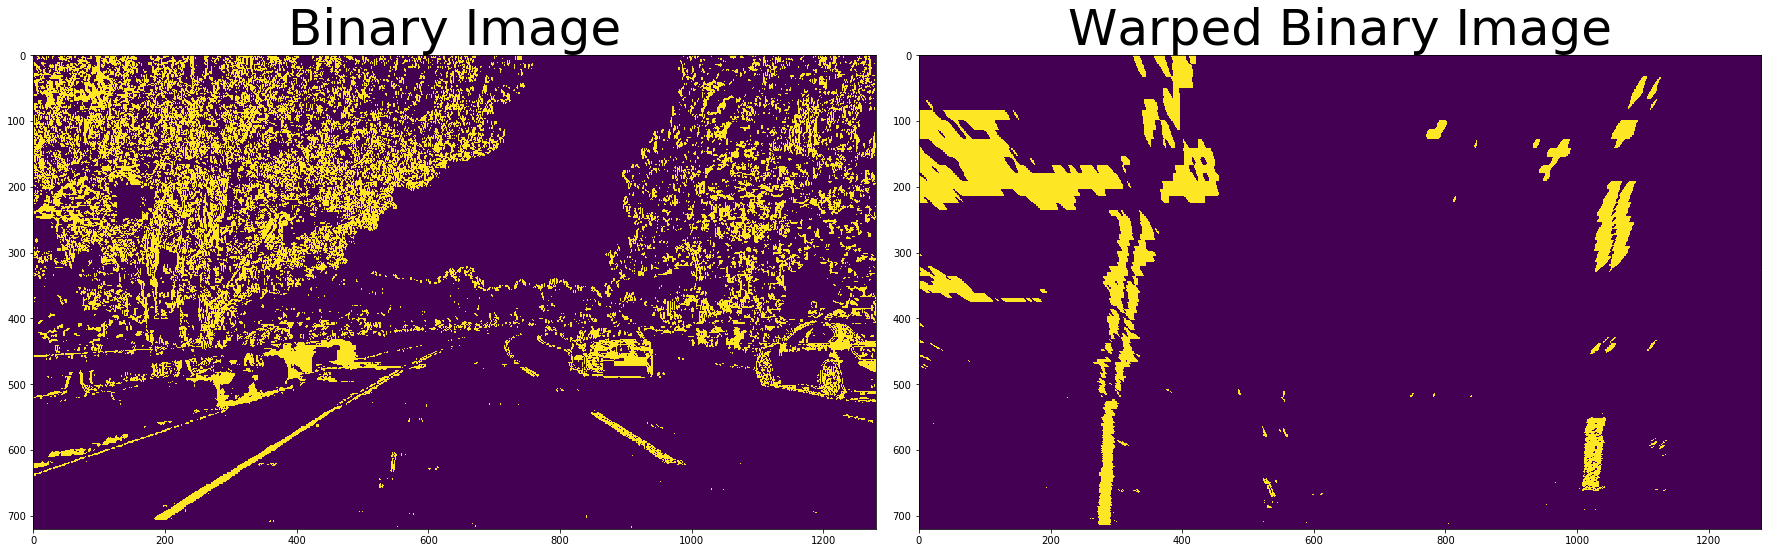

In [54]:
# testing output
rd = mpimg.imread('test_images/test5.jpg')
rd_und = cv2.undistort(rd, mtx, dist, None, mtx)
rd_bi = pipeline(rd_und)
# creating warped image
rd_bi_wrp = cv2.warpPerspective(rd_bi, M, (rd.shape[1], rd.shape[0]), flags=cv2.INTER_LINEAR)
# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rd_bi)
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(rd_bi_wrp)
ax2.set_title('Warped Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
# creating function for initial line search with windows
# will be used at the very beginning of the video or when lines are lost
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [12]:
# creating function for fitting polynomial from initial lines search
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, left_fitx, right_fitx

In [13]:
# functions for polynomial fit for sequential frames
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, left_fitx, right_fitx

In [14]:
# function to vizualize the lines on a blank image and calculate curve radius
def draw_lines(binary_warped, left_fit, right_fit, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Calculation of R_curve (radius of curvature)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return color_warp, left_curverad, right_curverad

In [15]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

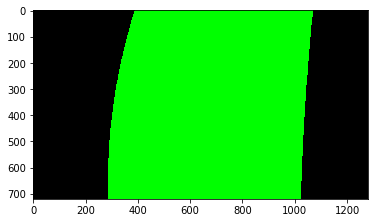

In [114]:
# testing the entire pipeline for a new image
rd = mpimg.imread('test_images/test5.jpg')
rd_und = cv2.undistort(rd, mtx, dist, None, mtx)
rd_bi = pipeline(rd_und)
rd_bi_wrp = cv2.warpPerspective(rd_bi, M, (rd.shape[1], rd.shape[0]), flags=cv2.INTER_LINEAR)
left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(rd_bi_wrp)
result, left_curverad, right_curverad = draw_lines(rd_bi_wrp, left_fit, right_fit, left_fitx, right_fitx)
plt.imshow(result)

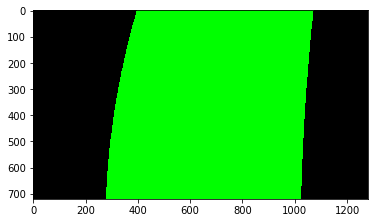

In [115]:
# testing for an image with known polynomial coefficients (reusing the same image)
left_fit, right_fit, left_fitx, right_fitx = search_around_poly(rd_bi_wrp, left_fit, right_fit)
result, left_curverad, right_curverad = draw_lines(rd_bi_wrp, left_fit, right_fit, left_fitx, right_fitx)
plt.imshow(result)

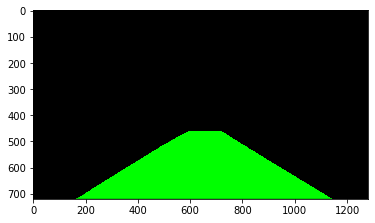

In [159]:
# creating reverse perspective transofrm
res = cv2.warpPerspective(result, M_reverse, (rd.shape[1], rd.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(res)

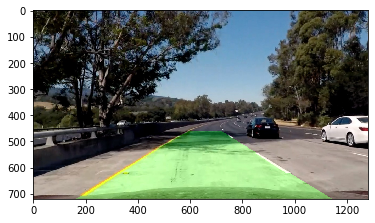

In [181]:
# overlaying with undistorted camera image
comb = cv2.addWeighted(rd_und, 1, res, 0.3, 0)
plt.imshow(comb)

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients storage
        self.polys = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

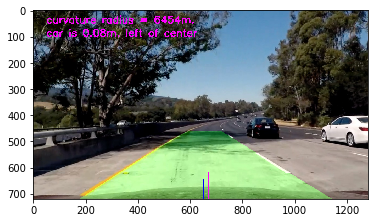

In [19]:
# create process for image processing
def process(img):
    # hyperparam: number of frames to remember
    num_fr = 10
    
    # undistort, create binary and warp of the lane area
    img_und = cv2.undistort(img, mtx, dist, None, mtx)
    img_bi = pipeline(img_und)
    img_bi_wrp = cv2.warpPerspective(img_bi, M, (img_bi.shape[1], img_bi.shape[0]), flags=cv2.INTER_LINEAR)
    
    # at the first run or in case if line is not found, run detection from scratch
    if left_line.detected is False or right_line.detected is False:
        left_line.current_fit, right_line.current_fit, left_line.recent_xfitted, right_line.recent_xfitted = \
                                                                                    fit_polynomial(img_bi_wrp)
        if np.any(left_line.current_fit):
            left_line.detected = True
        if np.any(right_line.current_fit):
            right_line.detected = True
    # if data for lines exist, use averaged polynomial coefficients
    else:
        left_line.current_fit, right_line.current_fit, left_line.recent_xfitted, right_line.recent_xfitted = \
                                        search_around_poly(img_bi_wrp, left_line.best_fit, right_line.best_fit)
    
    # calculate average polynomial coefficients for left line
    if left_line.polys is None:
        left_line.polys = np.array([left_line.current_fit])
    else:
        left_line.polys = np.vstack((left_line.polys, left_line.current_fit))
        if left_line.polys.shape[0] > num_fr:
            left_line.polys = np.delete(left_line.polys, (0), axis=0)
    left_line.best_fit = left_line.polys.mean(axis=0)
    # if all fits are zeros, set detected line property to False, so it's picked by lane finding from scratch
    if not np.any(left_line.polys):
        left_line.detected = False
    
    # calculate average polynomial coefficients for right line
    if right_line.polys is None:
        right_line.polys = np.array([right_line.current_fit])
    else:
        right_line.polys = np.vstack((right_line.polys, right_line.current_fit))
        if right_line.polys.shape[0] > num_fr:
            right_line.polys = np.delete(right_line.polys, (0), axis=0)
    right_line.best_fit = right_line.polys.mean(axis=0)
    # if all fits are zeros, set detected line property to False, so it's picked by lane finding from scratch
    if not np.any(right_line.polys):
        right_line.detected = False
    
    # calcualte average x values for num_fr last fits for left line
    if left_line.allx is None:
        left_line.allx = np.array([left_line.recent_xfitted])
    else:
        left_line.allx = np.vstack((left_line.allx, left_line.recent_xfitted))
        if left_line.allx.shape[0] > num_fr:
            left_line.allx = np.delete(left_line.allx, (0), axis=0)
    left_line.bestx = left_line.allx.mean(axis=0)
    
    # calcualte average x values for num_fr last fits for right line
    if right_line.allx is None:
        right_line.allx = np.array([right_line.recent_xfitted])
    else:
        right_line.allx = np.vstack((right_line.allx, right_line.recent_xfitted))
        if right_line.allx.shape[0] > num_fr:
            right_line.allx = np.delete(right_line.allx, (0), axis=0)
    right_line.bestx = right_line.allx.mean(axis=0)
    
    # create calculated lane mask
    result, left_curverad, right_curverad = draw_lines(img_bi_wrp, left_line.best_fit, right_line.best_fit, \
                                                       left_line.bestx, right_line.bestx)
    
    # reverse the perspective and apply onto undistorted input image
    result_persp = cv2.warpPerspective(result, M_reverse, (rd.shape[1], rd.shape[0]), flags=cv2.INTER_LINEAR)
    comb = cv2.addWeighted(img_und, 1, result_persp, 0.3, 0)
    
    # calculate base positions for both lines
    y_bottom = imshape[0]
    midpt = np.int_(imshape[1]/2)
    left_line.line_base_pos = left_line.best_fit[0]*y_bottom**2 + left_line.best_fit[1]*y_bottom + left_line.best_fit[2]
    right_line.line_base_pos = right_line.best_fit[0]*y_bottom**2 + right_line.best_fit[1]*y_bottom + right_line.best_fit[2]
    
    # reset lane search if lane lines are too close to the car center point
    if left_line.line_base_pos > (midpt - 200) or right_line.line_base_pos < (midpt + 200):
        left_line.detected = False
        left_line.polys = None
        left_line.allx = None
        right_line.detected = False
        right_line.polys = None
        right_line.allx = None
    
    # define positions for curvature and center indicators
    text_pos_left = (50, 50)
    text_pos_right = (50, 100)
    mark_lane_center = (np.int_((left_line.line_base_pos + right_line.line_base_pos)/2), 720)
    mark_car_center = (640, 720)
    # get car location from center in pixels
    diff_pix = np.int_(midpt - (left_line.line_base_pos + right_line.line_base_pos)/2)
    # convert to meters
    diff = abs(round(xm_per_pix * diff_pix, 2))
    if diff_pix > 0:
        car_loc = "right"
    elif diff_pix < 0:
        car_loc = "left"
    else:
        car_loc = ''
    
    # take mean curvature radius
    curverad = np.int_((left_curverad + right_curverad)/2)
    
    # add curvature information, car location, indicators for lane center and car center
    cv2.putText(comb, f"curvature radius = {curverad}m.", text_pos_left, cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 255), 3)
    cv2.putText(comb, f"car is {diff}m. {car_loc} of center", text_pos_right, cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 255), 3)
    cv2.putText(comb, "|", mark_lane_center, cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 255), 3)
    cv2.putText(comb, "|", mark_car_center, cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3)
    return comb

# test run on the image, output the result
img = mpimg.imread("test_images/test5.jpg")
# instantiate left and right lines
left_line = Line()
right_line = Line()
# run single image through pipeline
plt.imshow(process(img))

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [57]:
# reset line variables
left_line = Line()
right_line = Line()
# create the video using the pipeline
project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(project_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_output.mp4.
Moviepy - Writing video project_output.mp4



Moviepy - Done !
Moviepy - video ready project_output.mp4
CPU times: user 17min, sys: 15.2 s, total: 17min 15s
Wall time: 1min 28s


In [165]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [129]:
# reset line variables
left_line = Line()
right_line = Line()
# run against challenge video
challenge_output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(challenge_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video challenge_output.mp4.
Moviepy - Writing video challenge_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_output.mp4
CPU times: user 6min 15s, sys: 7.22 s, total: 6min 22s
Wall time: 32 s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [139]:
# reset line variables
left_line = Line()
right_line = Line()
# run against harder challenge video
hard_challenge_output = 'harder_challenge_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(hard_challenge_output, audio=False)

t:   0%|          | 2/1199 [00:00<01:04, 18.53it/s, now=None]

Moviepy - Building video harder_challenge_output.mp4.
Moviepy - Writing video harder_challenge_output.mp4



Moviepy - Done !
Moviepy - video ready harder_challenge_output.mp4
CPU times: user 15min 35s, sys: 8.48 s, total: 15min 43s
Wall time: 1min 33s


In [137]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hard_challenge_output))